# What this simulation hopes to achieve

1. Generate a map from a known power law in the $A_s$. Do this using `synfast`.
    
1. Generate the SED (spectral energy density) using the fact that $m_\nu = A_S \times \textrm{SED}(\nu)$. Use `anafast` to generate a map here.
    
1. Now allow the index to vary spatially, perhaps beginning with letting $\beta_s = -3 \pm \rm random$.
    
1. Generate new "realistic maps" using this spatially varying index: 
$$
m_\nu = A_s \times \textrm{SED}(\beta_s)
$$
    
1. From this, extract a power spectrum and compare it to the known power spectrum from before.

## Maths

The relevant equations here are
$$
\textrm{SED} = \left(\frac{\nu}{\nu_0}\right)^{2+\beta_s}
$$
with $\nu_0 \sim 30 \ \rm GHz$. The frequencies are typically in the range 20-300 GHZ. $\beta_s$ is typically about -3. The associated $A_s$s are also given by a power law
$$
C_\ell^s = A_s \times \left(\frac{\ell}{\ell_*}\right)^{\alpha_s}
$$
where typical $\ell$ are 2-500, $\ell_* = 80$ and $\alpha_s \sim -3$

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import healpy as hp

In [4]:
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS

## Section 1: Generating $A_s$ maps

In [5]:
#defines the ell power law that we will use for the A_s spectrum
def powerlaw(ell, alpha):
    return (ell/ 80.)**alpha

#defines a normal planck distribution 
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

In [6]:
#define the synchrotron SED.
"""I'm not 100% sure what is going on here, for example,
and what the [..., np.newaxis] is doing"""
"""Is beta an array so that we can allow it to vary with position?"""

#define what frequency map we want to look at. Start with 2.3 GHz
nu0 = 2.3e9 


def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit

In [7]:
#define the BB parameter values (to start)
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

In [8]:
"""set the nside parameter, which determines the 
resolution of the map. This should be a power of 2"""
nside = 128

In [9]:
#define an array of the input ell from 1 to ellmax, this avoids the division by 0 issue
Lmax = 384
ells = np.arange(1,Lmax+1)

In [27]:
"""not sure what I'm doing here. It is something related to
the C_ell."""
pcls = A_BB * powerlaw(ells, alpha_BB)
pcls[0] = 0 #this sets what will by the C_1 element =0 
pcls[1] = 0

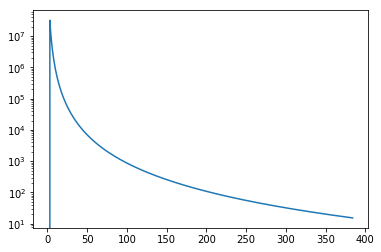

In [28]:
#how the C_ell vary with ell 
semilogy(ells,pcls)

This is the inputted power spectrum.

In [29]:
#produces the output map based on the given C_ell and the resolution desired.
sbb = hp.synfast(pcls, nside)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


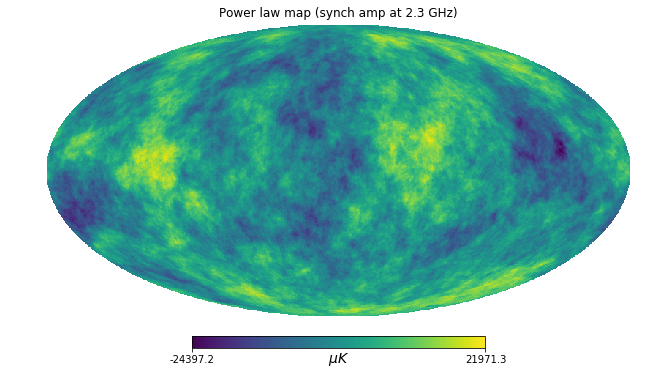

In [30]:
#view the map made above
hp.mollview(sbb, unit='$\mu K$', title='Power law map (synch amp at 2.3 GHz)')

In [31]:
#now extract the power spectrum (the C_ells) from the map
check_cls = hp.anafast(sbb)

(1, 100000000.0)

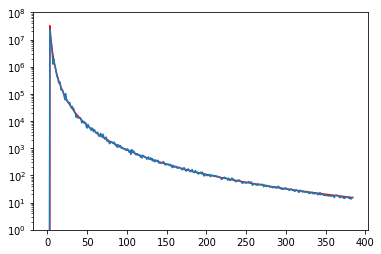

In [32]:
#compare the measured C_ell to the input C_ell curve
semilogy(ells, pcls, 'r')
semilogy(ells, check_cls)

ylim(1, 1e8)

We now want to put in the power law of the spectral energy density (SED).

## Section 2: Produce the full map including the SED

Recall that the full map is defined as 
$$
m_\nu = A_s \cdot \textrm{SED}(\nu)
$$
Now, as the $A_s$ is a power law we can write this as
$$
m_\nu = \left(\frac{\ell}{\ell_*}\right)^{\alpha_s} \times \left(\frac{\nu}{\nu_0}\right)^{\beta_s}
$$

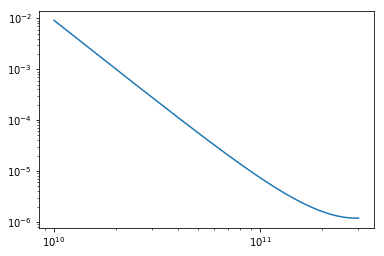

In [33]:
#define list of frequencies going from 10 to 200 GHz, sampling 20 points
freqs = np.linspace(10,300,20)*1.e9

#define the SED scaling
sed_scaling = scale_synch(freqs, beta_BB)

#plot the SED against frequency (on log log plot)
loglog(freqs, sed_scaling)

In [34]:
newmaps = sbb * sed_scaling[..., np.newaxis]
"""I don't totally get what's happening here. I don't understand
the slicing or what these maps are."""
newmaps.shape

(20, 196608)

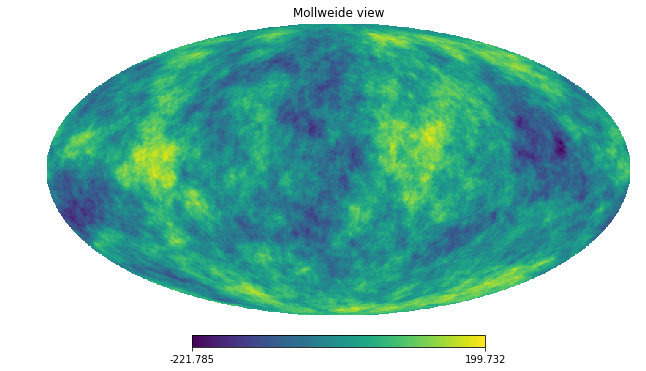

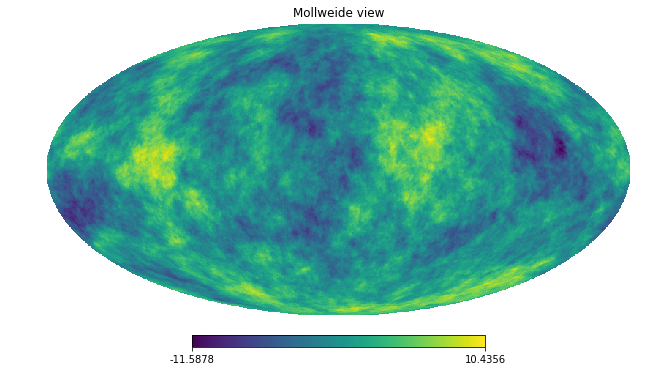

In [35]:
hp.mollview(newmaps[0])
hp.mollview(newmaps[1])